# Third task of the summer practice

---

Main goal is to build a classifier for road signs using the public dataset, and get accuracy $\geqslant\ 0.93$

In [5]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [6]:
# libraries
import numpy as np
from scipy.ndimage.filters import generic_filter1d
from skimage.filters import sobel_h, sobel_v
from skimage.transform import resize
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

In [7]:
def get_brightness(im):
     return 0.299 * im[:,:,0] + 0.587 * im[:,:,1] + 0.114 * im[:,:,2]

In [8]:
def crop_and_rescale(im):
    dim = max(im.shape)
    return resize(im[:dim,:dim], (64, 64), mode='constant')

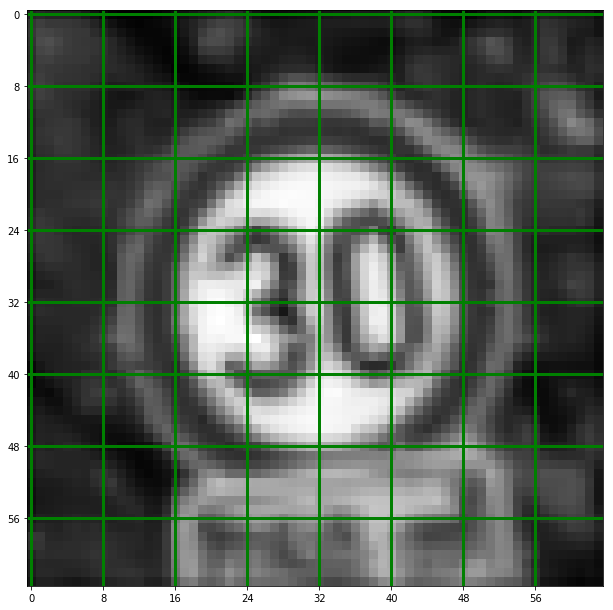

In [9]:
# sample image to try things out
im = crop_and_rescale(get_brightness(imread('./data/train/01155.png')))
fig=plt.figure(figsize=(15, 8))
ax=fig.add_subplot(111)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

# Set the gridding interval: here we use the major tick interval
myInterval=8
loc = plticker.MultipleLocator(base=myInterval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)

ax.grid(which='major', axis='both', linestyle='-', color='green', linewidth=3)
ax.imshow(im, cmap='gray')

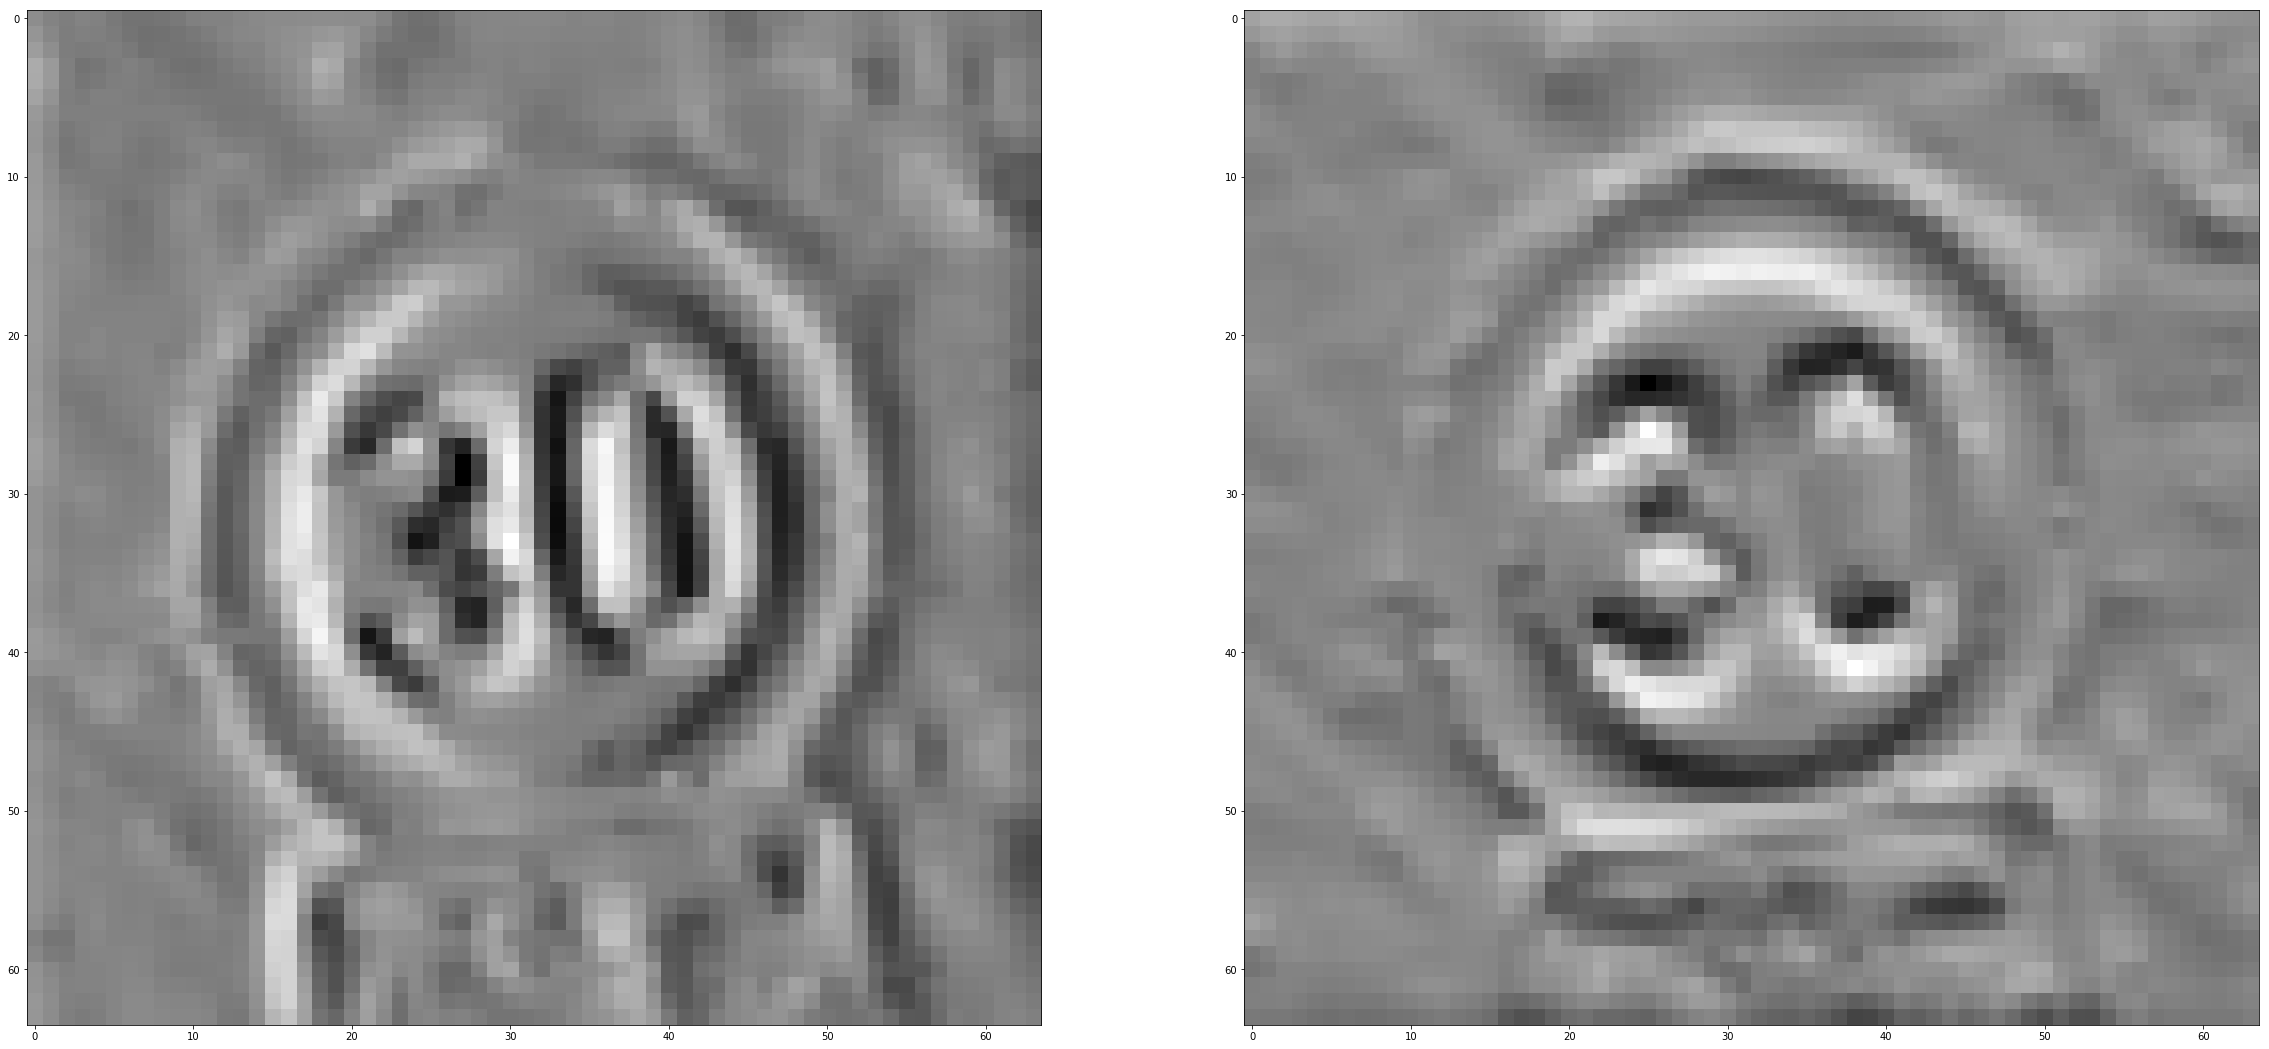

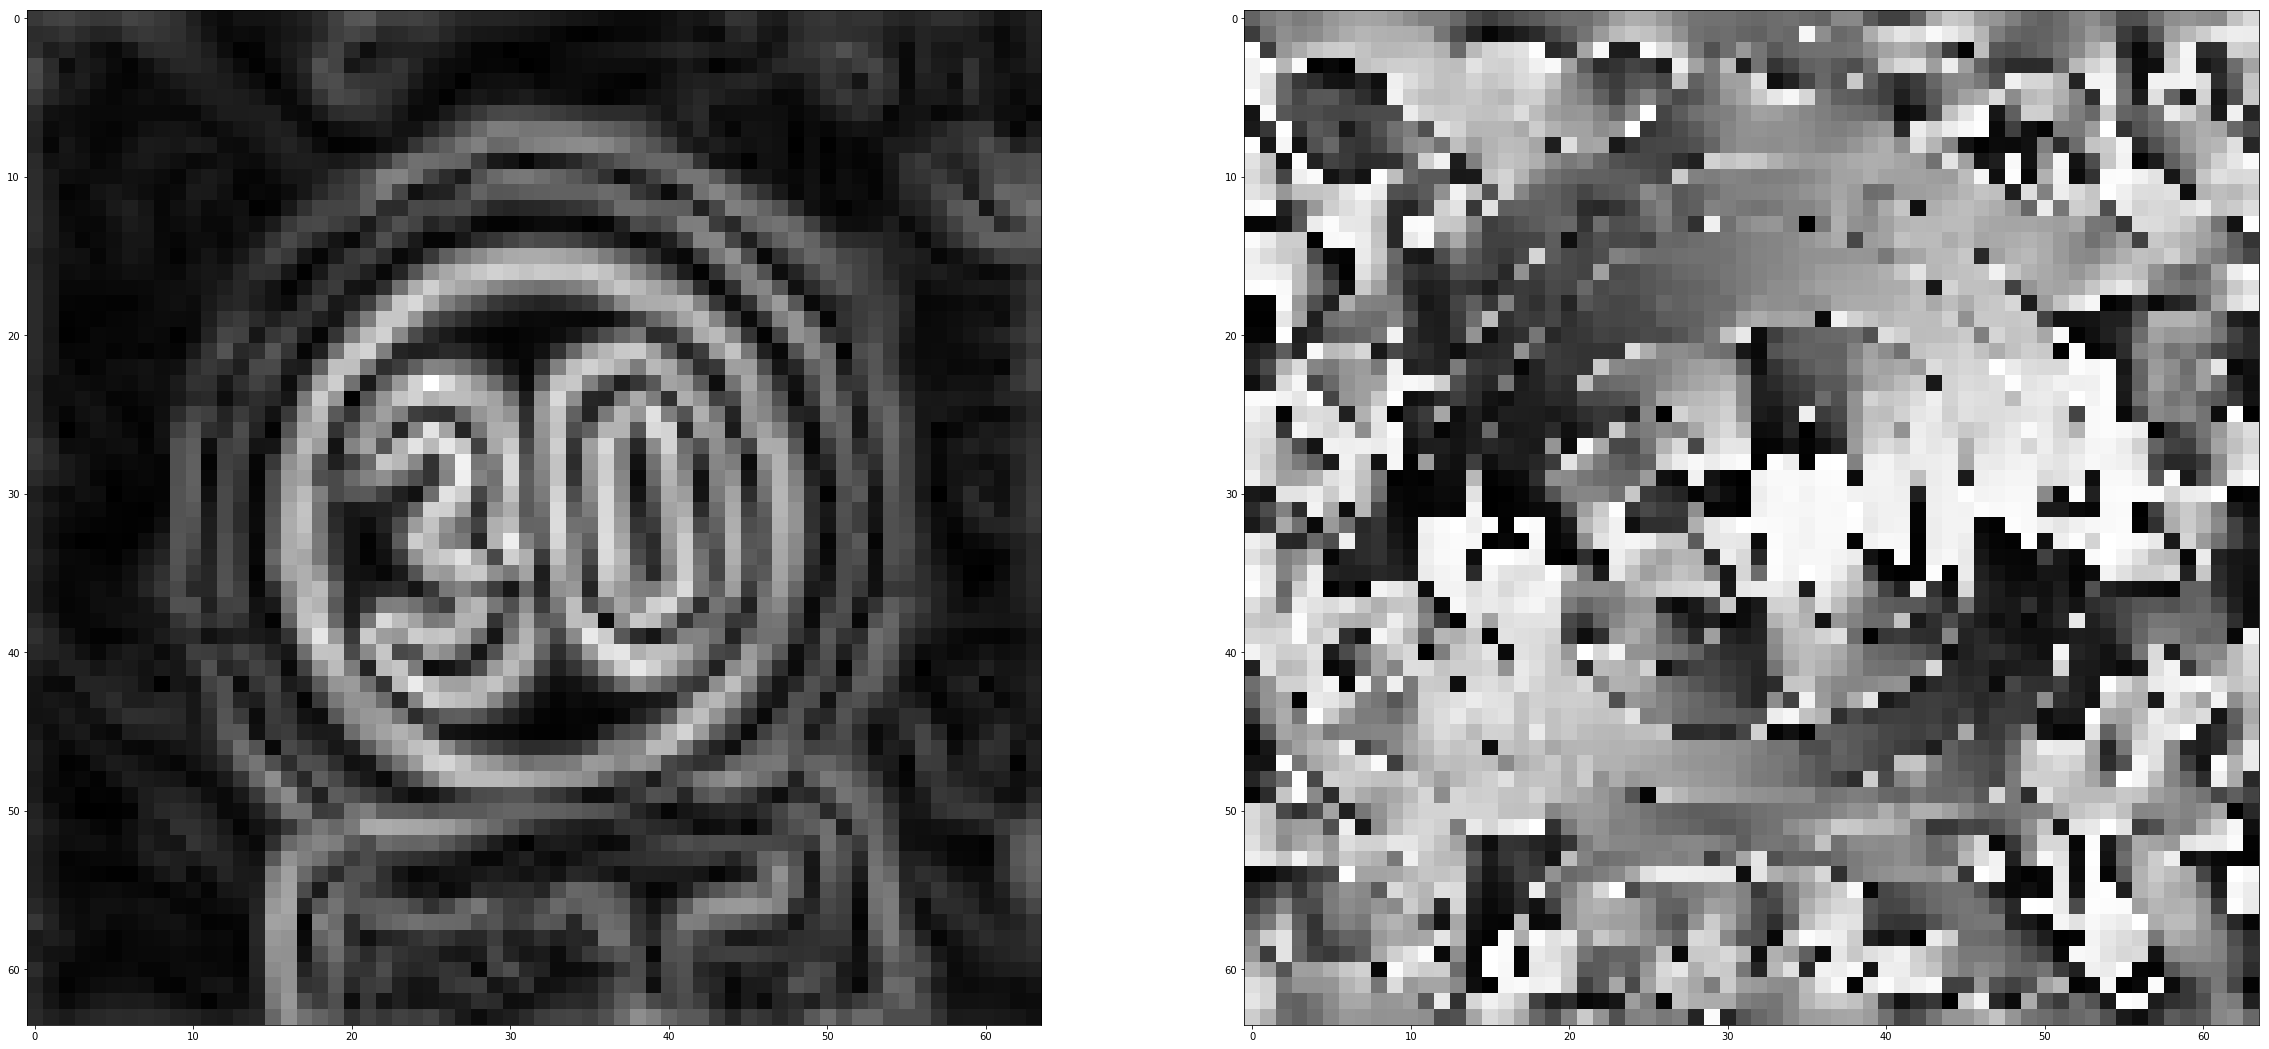

In [10]:
# find gradient magnitude and orientation
dy, dx = np.gradient(im, .5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))
ax1.imshow(dx, cmap='gray')
ax2.imshow(dy, cmap='gray')

mag = np.hypot(dx, dy)
ang = np.rad2deg(np.arctan2(dy, dx)) % 180

orientations = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))
ax1.imshow(mag, cmap='gray')
ax2.imshow(ang, cmap='gray')

In [11]:
def make_histogram(mag, ang, cell_x, cell_y, pos_x, pos_y, orientations):
    hist_vec = np.zeros((9,))
    for y in range(pos_y, pos_y + cell_y):
        for x in range(pos_x, pos_x + cell_x):
            cur_ang = ang[y, x]
            gr_ang = orientations[np.where(orientations >= cur_ang)[0][0]]
            sm_ang = gr_ang - 20
            cur_ang -= sm_ang
#             print(sm_ang, cur_ang, gr_ang)
            hist_vec[gr_ang // 20 % 9] += (cur_ang / 20) * mag[y, x]
            hist_vec[sm_ang // 20 % 9] += (1 - cur_ang / 20) * mag[y, x]
    return hist_vec
     
myfv = make_histogram(mag, ang, 8, 8, 0, 0, orientations)
print(myfv)

[ 172.22883324   57.8295911   101.58079549   79.04490176  121.61766369
  195.39486179  146.45642543   70.2260159    79.99829584]


In [12]:
def extract_hog(im):
    im = np.sqrt(im)
    dy, dx = np.gradient(im, .5)
    
    mag = np.hypot(dx, dy)
    ang = np.rad2deg(np.arctan2(dy, dx)) % 180

    orientations = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
    
    cell_x, cell_y = (8, 8)
    block_x, block_y = (2, 2)

    count_x = im.shape[1] // cell_x
    count_y = im.shape[0] // cell_y

    histograms = np.zeros((count_y, count_x, 9))

    for y in range(count_y):
        for x in range(count_x):
            histograms[y, x] = make_histogram(mag, ang, cell_x, cell_y, cell_x * x, cell_y * y, orientations)


    count_bx = count_x - block_x + 1
    count_by = count_y - block_y + 1
    normalized = np.zeros((count_by, count_bx, block_y, block_x, 9))
    for y in range(count_by):
        for x in range(count_bx):
            block = histograms[y:y + block_y, x:x + block_x, :]
            normalized[y,x,:] = block / np.sqrt(np.sum(block ** 2) + 1e-10)

    return normalized.ravel()

## Playground is under this heading

---


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [14]:
data = pd.read_csv('./data/train/gt.csv', sep=',')
print(data.values)

[['00000.png' 0]
 ['00001.png' 0]
 ['00002.png' 0]
 ..., 
 ['39206.png' 42]
 ['39207.png' 42]
 ['39208.png' 42]]


In [36]:
X = []
for row in log_progress(data.values):
    im = crop_and_rescale(get_brightness(imread('./data/train/' + row[0])))
    fv = extract_hog(im)
    X.append(fv)
X = np.array(X)
y = data.values[:,1:]
y = y.reshape((y.size,)).astype('int64')

In [32]:
from skimage.feature import hog
X_lib = []
for row in log_progress(data.values):
    im = crop_and_rescale(get_brightness(imread('./data/train/' + row[0])))
    fv = hog(im, cells_per_block=(2,2), block_norm='L1-sqrt')
    X_lib.append(fv)
X_lib = np.array(X_lib)
y = data.values[:,1:]
y = y.reshape((y.size,)).astype('int64')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_lib, y, test_size=.33, random_state=133)

In [52]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1e5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
# score = cross_val_score(clf, X, y, cv=4, n_jobs=2)

0.978271957564


In [ ]:
y = clf.predict(X_test)
print('Accuracy: %.4f' % (sum(y_test == y) / float(y_test.shape[0])))

In [39]:
print(np.mean(score))

0.922139923625


In [45]:
score

array([ 0.92529556,  0.90857201,  0.93076687,  0.92392525])

In [53]:
clf.score(X_train, y_train)

KeyboardInterrupt: 